In [ ]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../utils_mapping.R')
})


In [3]:
library(biomaRt)

# ID fibroblasts

## (GEO) counts

In [17]:
# exprs_hc <- fread('/data/srlab/ik936/Roche/data/mouse/GSE114374_Mouse_HC_expression_matrix.txt.gz') %>% 
#     data.frame() %>% 
#     tibble::column_to_rownames('V1') %>% 
#     as.matrix() %>% 
#     as('dgCMatrix')


# exprs_hc[1:5, 1:5]
# head(exprs_hc@x)

# exprs_dss <- fread('/data/srlab/ik936/Roche/data/mouse/GSE114374_Mouse_DSS_expression_matrix.txt.gz') %>% 
#     data.frame() %>% 
#     tibble::column_to_rownames('V1') %>% 
#     as.matrix() %>% 
#     as('dgCMatrix')


# exprs_dss[1:5, 1:5]

# dim(exprs_hc)
# dim(exprs_dss)

# g <- intersect(rownames(exprs_hc), rownames(exprs_dss))

# colnames(exprs_hc) <- sprintf('%s_hc', colnames(exprs_hc))
# colnames(exprs_dss) <- sprintf('%s_dss', colnames(exprs_dss))

# exprs_raw <- Matrix::cbind2(exprs_hc[g, ], exprs_dss[g, ])

# dim(exprs_raw)

## (KB) counts

In [4]:
exprs_raw <- readRDS('/data/srlab/ik936/Roche/data/cache/exprs_raw_matrix_mouse_dss.rds')


In [5]:
exprs_raw[1:5, 1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
              AAACCTGAGTCTTGCA_DSS1 AAACCTGTCCACGAAT_DSS1 AAACCTGTCCTCAATT_DSS1
0610009B22Rik                     .                     .                     .
0610010F05Rik                     .                     .                     .
0610010K14Rik                     .                     .                     .
0610012G03Rik                     .                     1                     .
0610030E20Rik                     .                     .                     .
              AAACGGGAGAACAATC_DSS1 AAACGGGGTTCCGGCA_DSS1
0610009B22Rik                     .                     .
0610010F05Rik                     .                     .
0610010K14Rik                     .                     .
0610012G03Rik                     .                     .
0610030E20Rik                     .                     .

Let's confirm that we are looking at counts, not normalized data. 

In [8]:
head(exprs_raw@x)

[1] 1 1 1 1 1 1

## Metadata

In [11]:
mito_genes <- grep("^MT-", rownames(exprs_raw), value = TRUE, ignore.case = TRUE)
meta_data <- tibble(
    CellID = colnames(exprs_raw),
#     RepID = gsub('^.*?\\.(\\d)_(.*$)', '\\1', colnames(exprs_raw)),
#     Status = gsub('^.*?\\.(\\d)_(.*$)', '\\2', colnames(exprs_raw)),
    RepID = gsub('^.*?_(.+)(\\d)', '\\2', colnames(exprs_raw)),
    Status = gsub('^.*?_(.+)(\\d)', '\\1', colnames(exprs_raw)),
    nGene = Matrix::colSums(exprs_raw != 0), 
    nUMI = Matrix::colSums(exprs_raw), 
    percent_mito = Matrix::colSums(exprs_raw[mito_genes, ])/Matrix::colSums(exprs_raw),
    LibraryID = paste0(Status, RepID)
)  
    


In [12]:
head(meta_data)

CellID,RepID,Status,nGene,nUMI,percent_mito,LibraryID
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
AAACCTGAGTCTTGCA_DSS1,1,DSS,537,755,0.025165563,DSS1
AAACCTGTCCACGAAT_DSS1,1,DSS,2120,4885,0.013510747,DSS1
AAACCTGTCCTCAATT_DSS1,1,DSS,1002,2224,0.016187050,DSS1
AAACGGGAGAACAATC_DSS1,1,DSS,3145,10497,0.010288654,DSS1
AAACGGGGTTCCGGCA_DSS1,1,DSS,2590,7939,0.012847966,DSS1
AAAGATGAGAAGGGTA_DSS1,1,DSS,2561,6889,0.007693424,DSS1


## QC

Picking joint bandwidth of 0.0386



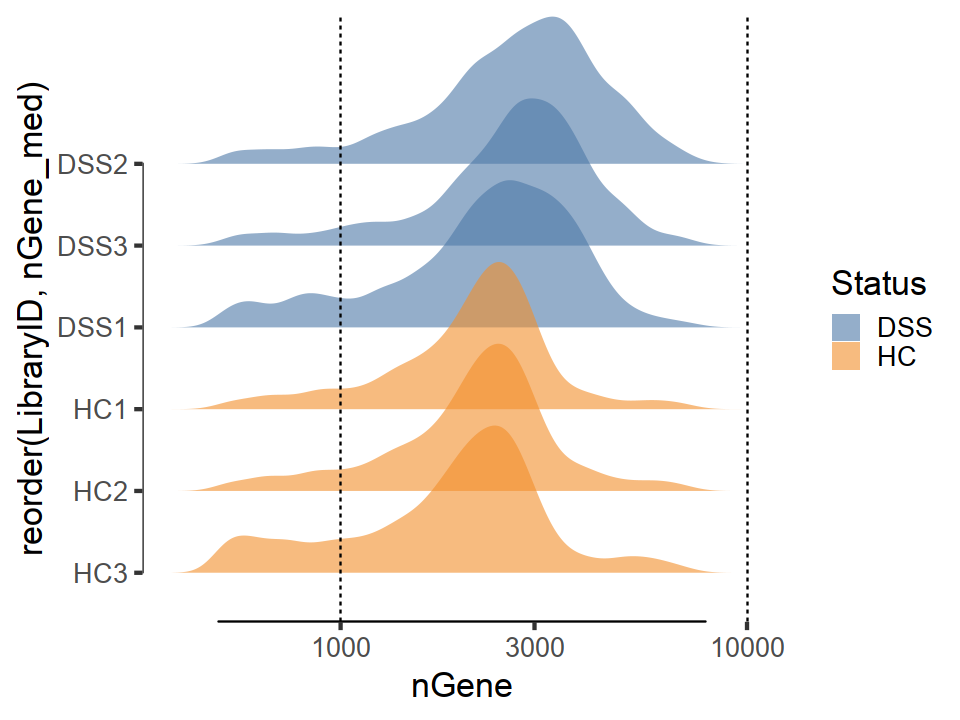

In [13]:
fig.size(6, 8)
# data.table(meta_data)[, nUMI_med := median(nUMI), by = LibraryID][] %>% 
#     ggplot(aes(nUMI, reorder(LibraryID, nUMI_med), fill = Case)) + 
data.table(meta_data)[, nGene_med := median(nGene), by = LibraryID][] %>% 
    ggplot(aes(nGene, reorder(LibraryID, nGene_med), fill = Status)) + 
        geom_density_ridges2(aes(height = ..ndensity..), alpha = .6, color = NA) + 
        theme_tufte(base_size = 20) + geom_rangeframe(color = 'black') + 
        scale_x_continuous(trans = 'log10') + 
        geom_vline(xintercept = c(1e3, 1e4), linetype = 2) + 
        scale_fill_tableau() + 
        NULL


In [16]:
meta_data <- meta_data %>% 
    subset(nGene > 1000 & percent_mito < .2)

In [17]:
exprs_raw <- exprs_raw[, meta_data$CellID]

## Doublets

In [53]:
library(dplyr)
library(future)
library(furrr)
library(scDblFinder)
library(scater)
library(singlecellmethods)
library(tibble)


scDblFinder_par <- function(counts, library_ids, logcounts=NULL, ncore=1) {
    if (is.null(logcounts)) {
        logcounts <- singlecellmethods::normalizeData(counts, 1e4, 'log')
    }
    logcounts_list <- split(seq_len(ncol(counts)), library_ids) %>% 
        map(function(idx) {
            logcounts[, idx]
        })

    counts_list <- split(seq_len(ncol(counts)), library_ids) %>% 
        map(function(idx) {
            counts[, idx]
        })

    if (ncore == 1) {
        future::plan(sequential)
    } else if (ncore %in% c(0, Inf)) {
        ncore <- availableCores()
        future::plan(multiprocess)
    } else {
        ## TODO: remove this assignment that pollutes the global environment 
        .ncore <<- ncore
        future::plan(future::multiprocess(workers = .ncore))
    }
    future_map2(logcounts_list, counts_list, function(.logcounts, .counts) {
            sce <- SingleCellExperiment(list(counts = .counts,logcounts = .logcounts))
            sce <- scDblFinder(sce, verbose=FALSE)
            as.data.frame(sce@colData) %>% 
                tibble::rownames_to_column('CellID')
        }) %>% 
        bind_rows(.id = 'LibraryID')
}


In [54]:
dbl_res <- scDblFinder_par(
    counts = exprs_raw,
    library_ids = meta_data$LibraryID,
    ncore = 16
)


In [59]:
meta_data <- meta_data %>% 
    left_join(dbl_res) 

Joining, by = c("CellID", "LibraryID")



In [68]:
with(meta_data, table(scDblFinder.class, LibraryID))
round(prop.table(with(meta_data, table(scDblFinder.class, LibraryID)), 2), 2)

                 LibraryID
scDblFinder.class DSS1 DSS2 DSS3  HC1  HC2  HC3
          doublet   23   10   16   20   23   22
          singlet 1507 1019 1290 1366 1510 1421

                 LibraryID
scDblFinder.class DSS1 DSS2 DSS3  HC1  HC2  HC3
          doublet 0.02 0.01 0.01 0.01 0.02 0.02
          singlet 0.98 0.99 0.99 0.99 0.98 0.98

Picking joint bandwidth of 0.0275



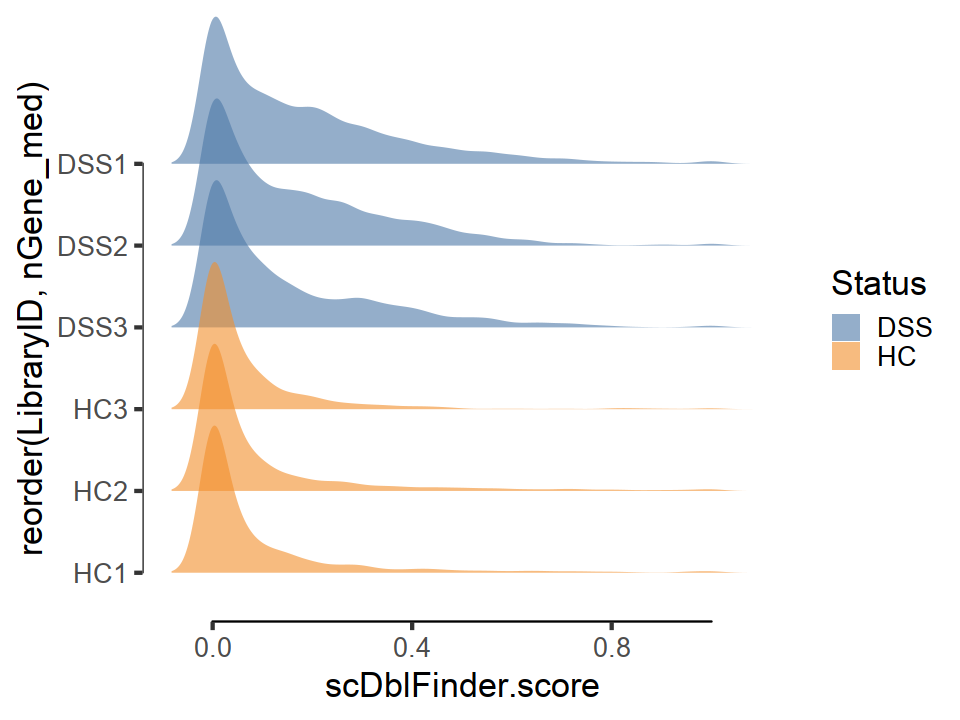

In [65]:
fig.size(6, 8)
data.table(meta_data)[, nGene_med := median(scDblFinder.score), by = LibraryID][] %>% 
    ggplot(aes(scDblFinder.score, reorder(LibraryID, nGene_med), fill = Status)) + 
        geom_density_ridges2(aes(height = ..ndensity..), alpha = .6, color = NA) + 
        theme_tufte(base_size = 20) + geom_rangeframe(color = 'black') + 
        scale_fill_tableau() + 
        NULL


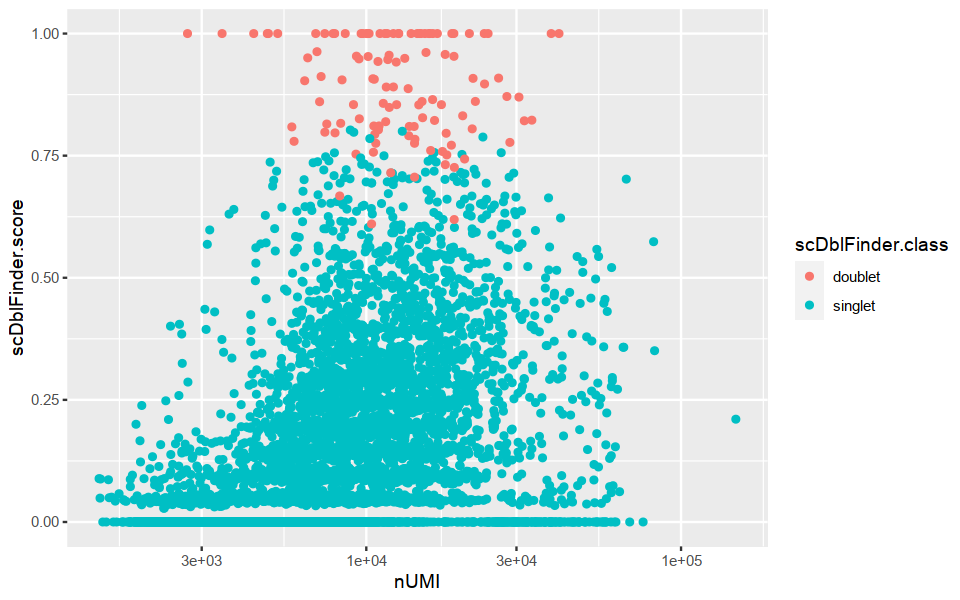

In [72]:
fig.size(5, 8)
meta_data %>% 
    ggplot(aes(nUMI, scDblFinder.score, color = scDblFinder.class)) + 
        geom_point() + 
        scale_x_log10()


# Call out fibroblasts

In [13]:
# obj <- readRDS('/data/srlab/ik936/Roche/data/cache/gut_obj_mouse_all.rds')

## Create object

start filter

Warning message in create_object(exprs_raw, meta_data %>% subset(scDblFinder.class == :
“weights not initialized in metadata. Setting all to 1.”
start normalization

start vargenes

start pca

use_weights



[1] FALSE


use_weights

use_weights



[1] FALSE


use_weights

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
“invalid uid value replaced by that for user 'nobody'”


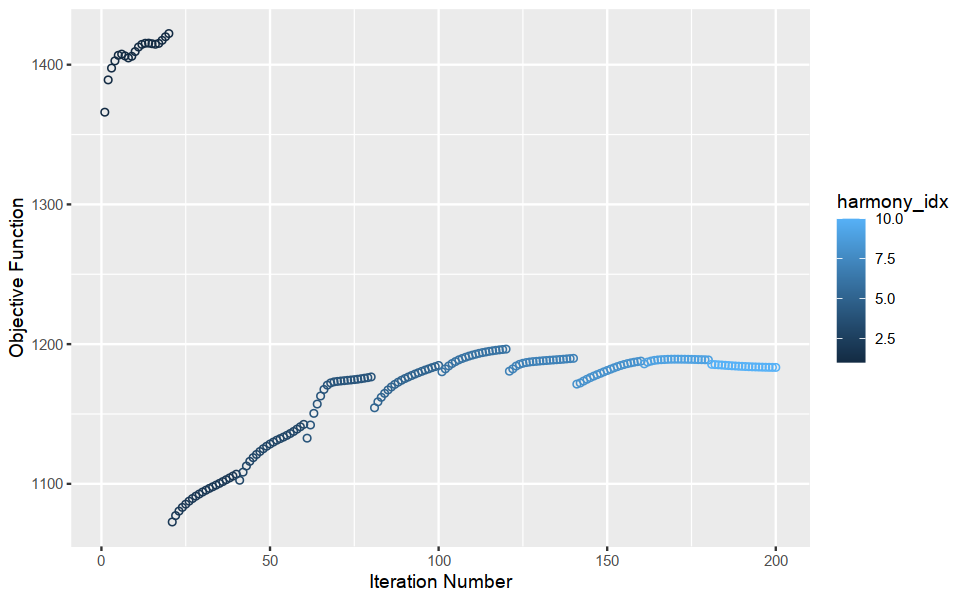

In [73]:
fig.size(5, 8)
set.seed(1)
strom <- create_object(
    exprs_raw, 
    meta_data %>% subset(scDblFinder.class == 'singlet')
) %>% 
# strom <- create_object(obj$exprs_raw, obj$meta_data) %>% 
    do_harmony(
        'LibraryID', theta=0.5, 
        max.iter.harmony=10, max.iter.cluster=20,
        epsilon.cluster = -Inf, epsilon.harmony = -Inf, 
#         weights = m$weight,
        plot_convergence = TRUE
    )

# %>% 
#     do_cluster(c(.1, .2, .3, .4))


In [74]:
future::plan(multiprocess)
set.seed(3)
t_cluster <- system.time({
    strom <- do_cluster(
        strom, 'adj_after', c(.1, .3, .5),
        append_cols = FALSE, 
        slot_name = 'clusters_df', 
        do_weights = FALSE
    )
})


0.1

0.3

0.5

New names:
* NA -> ...1
* NA -> ...2
* NA -> ...3

finished Louvain



Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


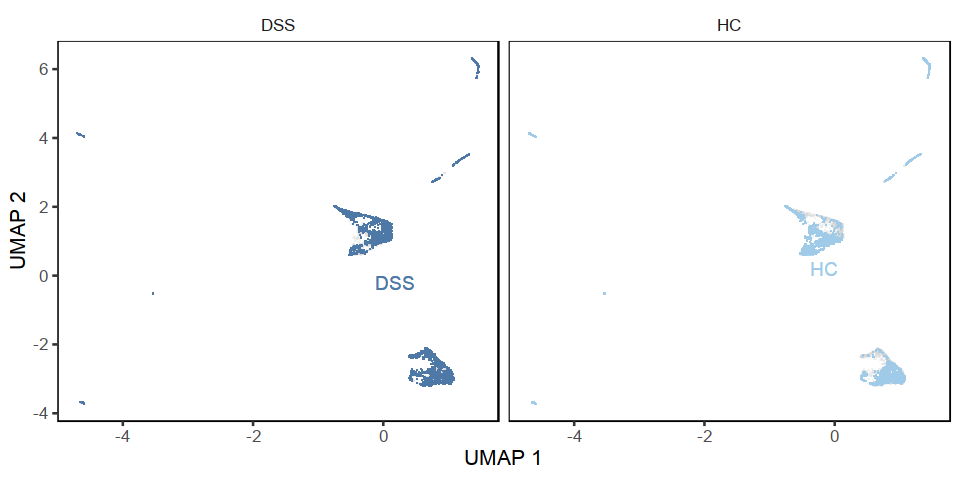

In [75]:
fig.size(4, 8)
do_scatter(strom$umap_after, strom$meta_data, 'Status', quo(Status))


## Lineage

In [76]:
lineage_markers <- list(
#     epithelial = c('EPCAM', 'CDH1'),
    endothelial = c('VWF', 'NOTCH4', 'PODXL'),
    mural = c('NOTCH3', 'ACTA2', 'MCAM', 'MYH11'),
    fibroblast = c('PDGFRA', 'PDPN', 'ABCA8'),
    haematopoietic = c('PTPRC', 'CD3E', 'CD79', 'LYVE1')
#     glial = c('CRYAB', 'S100B')
) %>% 
    map(stringr::str_to_sentence)


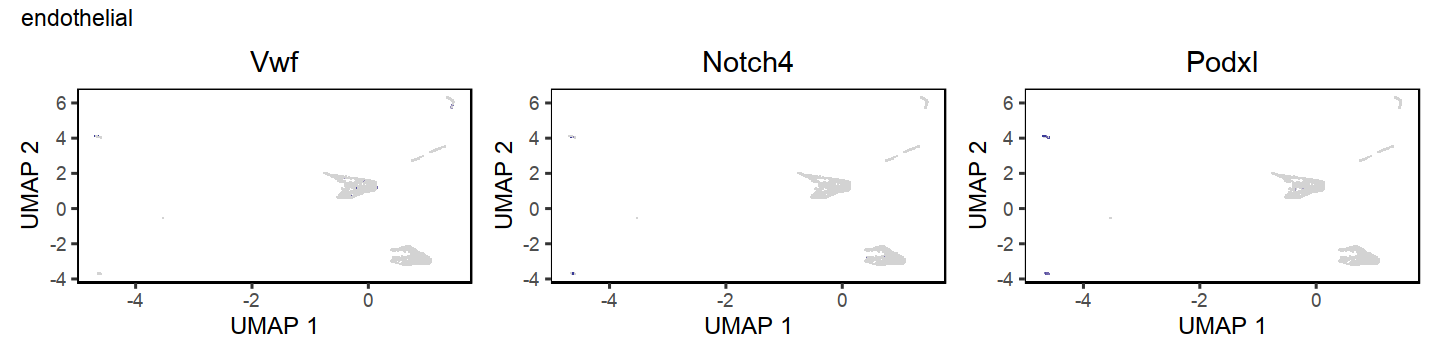

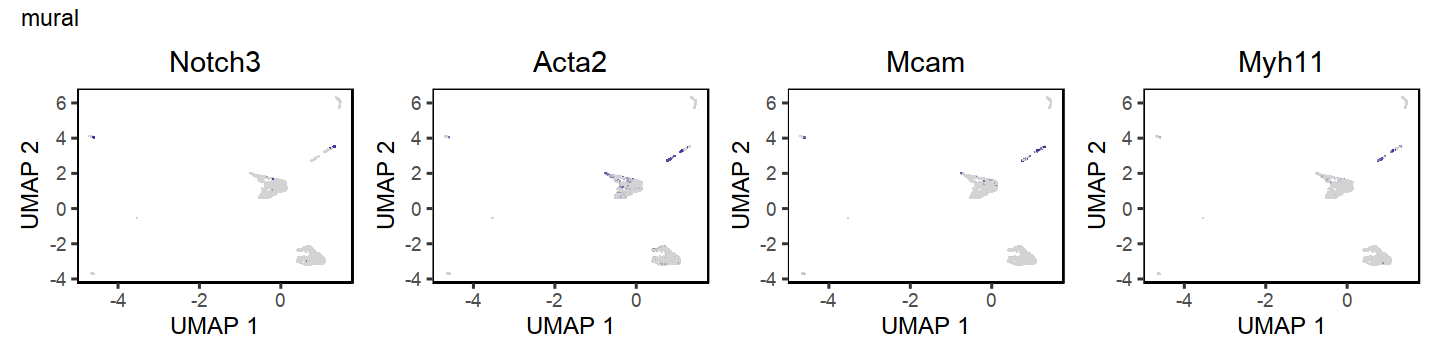

[[1]]

[[2]]

[[3]]

[[4]]


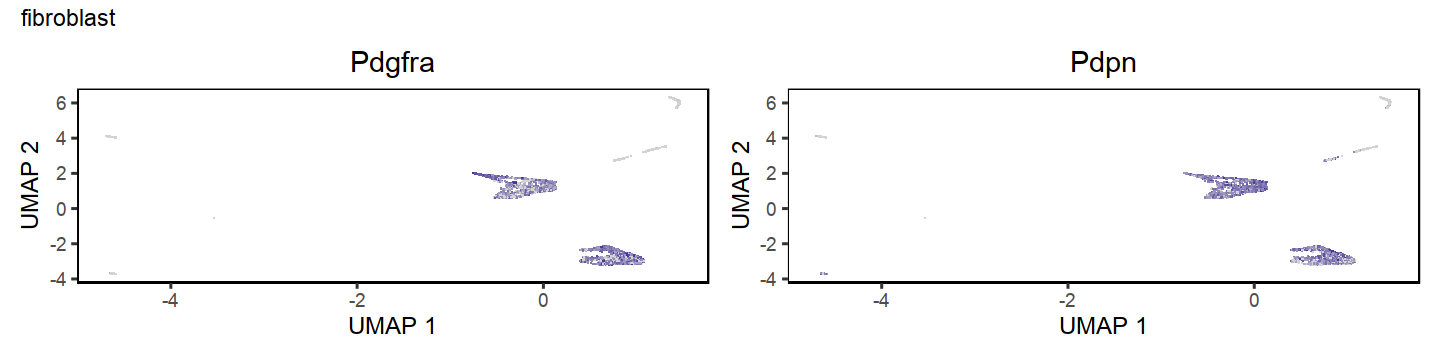

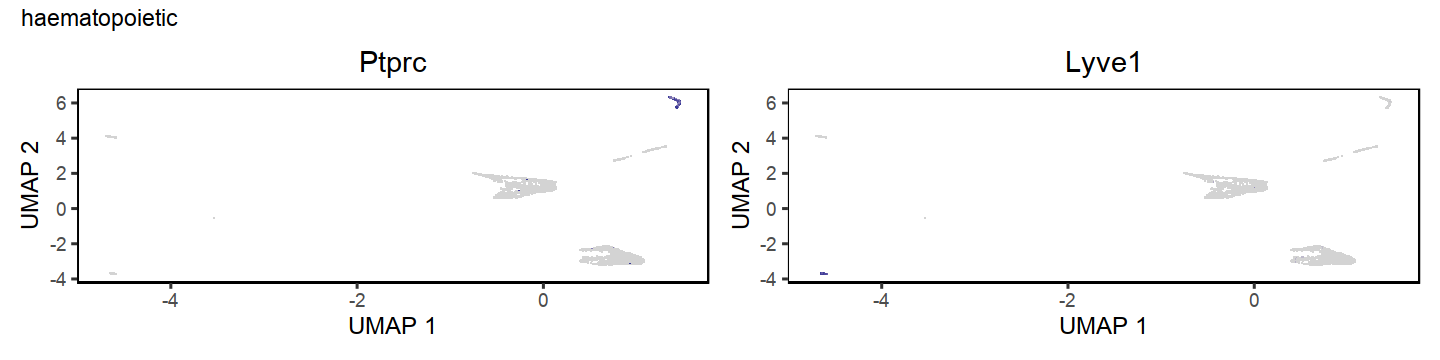

In [77]:
fig.size(3, 12)
with(strom, {
    lapply(names(lineage_markers), function(group) {
        plotFeatures(exprs_norm, umap_after,
                     intersect(lineage_markers[[group]], row.names(exprs_norm)), 
                     qhi = .99, no_guide = TRUE) + 
            plot_annotation(title = group)
    })    
})


Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


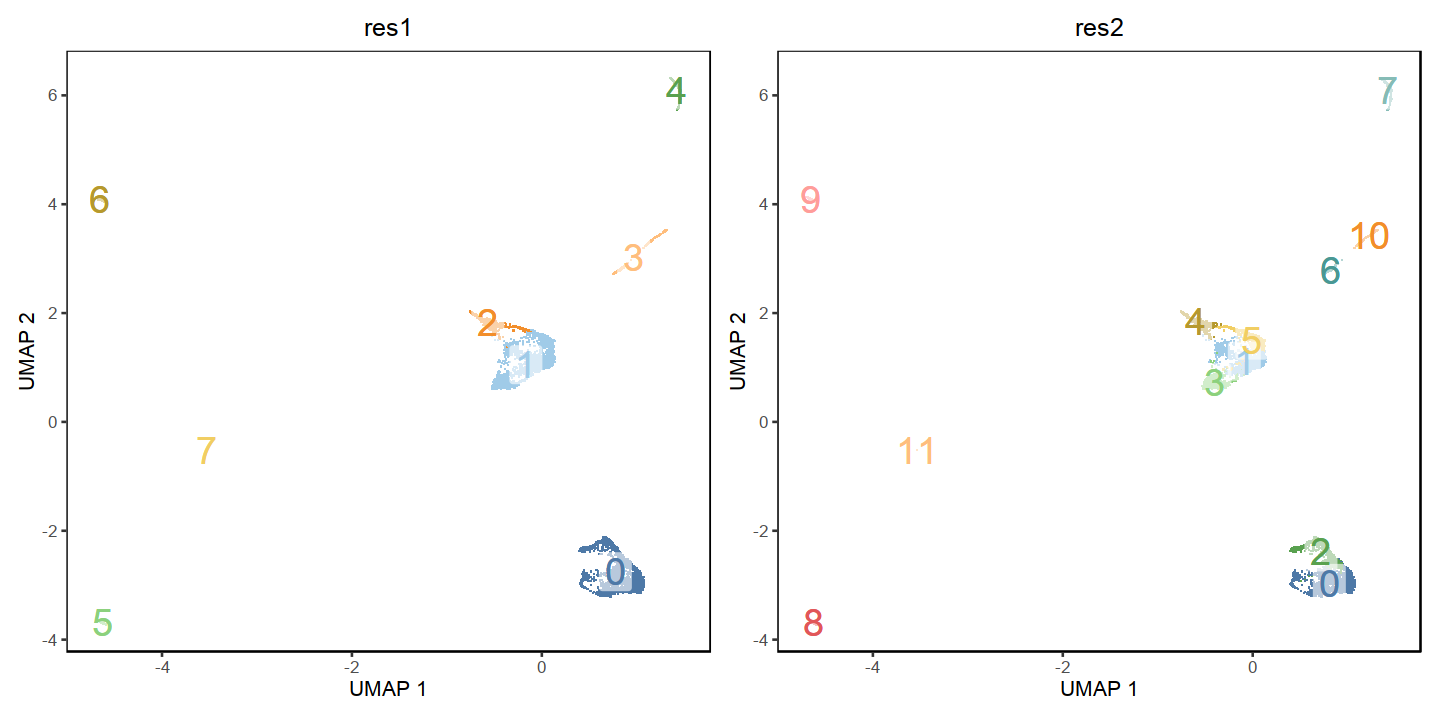

In [79]:
fig.size(6, 12)
plot_clusters(strom, 'umap_after', c('res1', 'res2'))

In [80]:
strom$meta_data$lineage <- case_when(
    strom$clusters_df$res2 %in% c('6') ~ 'myofibroblast',
    strom$clusters_df$res1 %in% c('5') ~ 'lymphatic_endothelial',
    strom$clusters_df$res1 %in% c('6') ~ 'vascular_endothelial',
    strom$clusters_df$res1 %in% c('0', '1', '2') ~ 'fibroblast',
    strom$clusters_df$res1 %in% c('3') ~ 'mural'
)


Warning message:
“Removed 376 rows containing missing values (geom_point).”


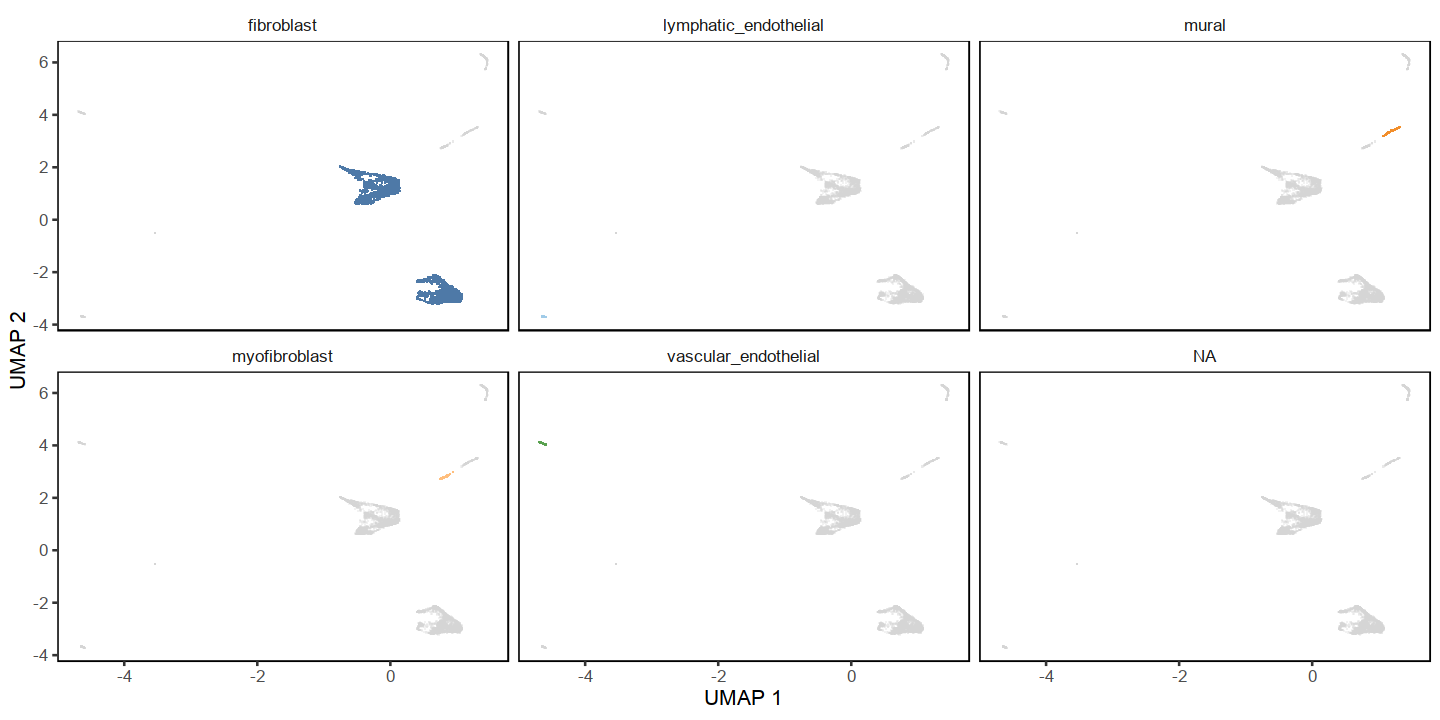

In [81]:
fig.size(6, 12)
do_scatter(strom$umap_after, strom$meta_data, 'lineage', quo(lineage), nrow = 2, pt_size = 8, do_labels = FALSE)


In [82]:
with(strom$meta_data, table(LibraryID, lineage))
with(strom$meta_data, table(LibraryID, lineage)) %>% prop.table(2) %>% round(2)


         lineage
LibraryID fibroblast lymphatic_endothelial mural myofibroblast
     DSS1       1306                    37    33            45
     DSS2        807                    31    33            55
     DSS3       1123                    25    30            47
     HC1        1076                    64    46            68
     HC2        1199                    67    49            74
     HC3        1078                    50    36           101
         lineage
LibraryID vascular_endothelial
     DSS1                   31
     DSS2                   25
     DSS3                   21
     HC1                    62
     HC2                    65
     HC3                    53

         lineage
LibraryID fibroblast lymphatic_endothelial mural myofibroblast
     DSS1       0.20                  0.14  0.15          0.12
     DSS2       0.12                  0.11  0.15          0.14
     DSS3       0.17                  0.09  0.13          0.12
     HC1        0.16                  0.23  0.20          0.17
     HC2        0.18                  0.24  0.22          0.19
     HC3        0.16                  0.18  0.16          0.26
         lineage
LibraryID vascular_endothelial
     DSS1                 0.12
     DSS2                 0.10
     DSS3                 0.08
     HC1                  0.24
     HC2                  0.25
     HC3                  0.21

## Map exprs_raw to human genes

In [83]:
human_genes <- rownames(readRDS('/data/srlab/ik936/Roche/data/cache/gut_obj_stromal.rds')$exprs_raw)

In [84]:
strom$exprs_raw_hs <- map_species(strom$exprs_raw, human_genes, from='mouse', to='human', orthologs_table=NULL, round_fxn=identity)


No orthologues DF provided, pulling data from Biomart



In [85]:
dim(strom$exprs_raw_hs)

[1] 17500  8113

In [86]:
dim(strom$exprs_raw)

[1] 21900  8113

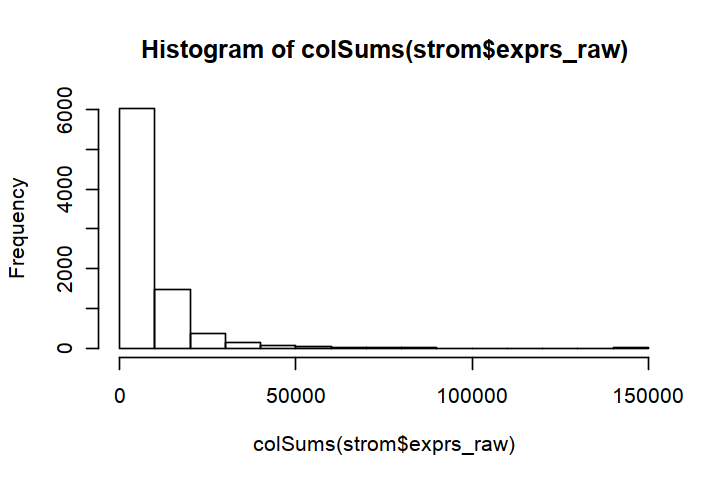

In [87]:
fig.size(4, 6)
hist(colSums(strom$exprs_raw))

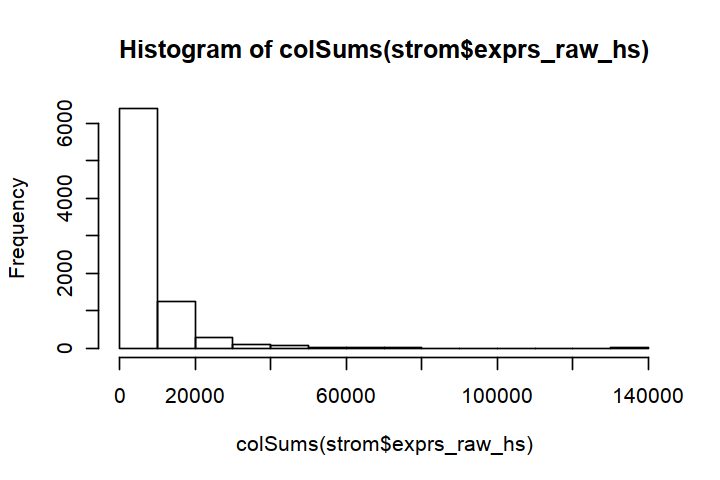

In [88]:
fig.size(4, 6)
hist(colSums(strom$exprs_raw_hs))

In [90]:
strom$meta_data %>% with(table(LibraryID, lineage))

         lineage
LibraryID fibroblast lymphatic_endothelial mural myofibroblast
     DSS1       1306                    37    33            45
     DSS2        807                    31    33            55
     DSS3       1123                    25    30            47
     HC1        1076                    64    46            68
     HC2        1199                    67    49            74
     HC3        1078                    50    36           101
         lineage
LibraryID vascular_endothelial
     DSS1                   31
     DSS2                   25
     DSS3                   21
     HC1                    62
     HC2                    65
     HC3                    53

## Cache

In [89]:
saveRDS(strom, '/data/srlab/ik936/Roche/data/cache/gut_obj_mouse_stromal.rds')

In [24]:
strom <- readRDS('/data/srlab/ik936/Roche/data/cache/gut_obj_mouse_stromal.rds')